In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import utils
import os
#%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

#from IPython.display import SVG, Image
#from livelossplot import PlotLossesKeras
# from livelossplot import PlotLossesTensorFlowKeras
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 1.14.0


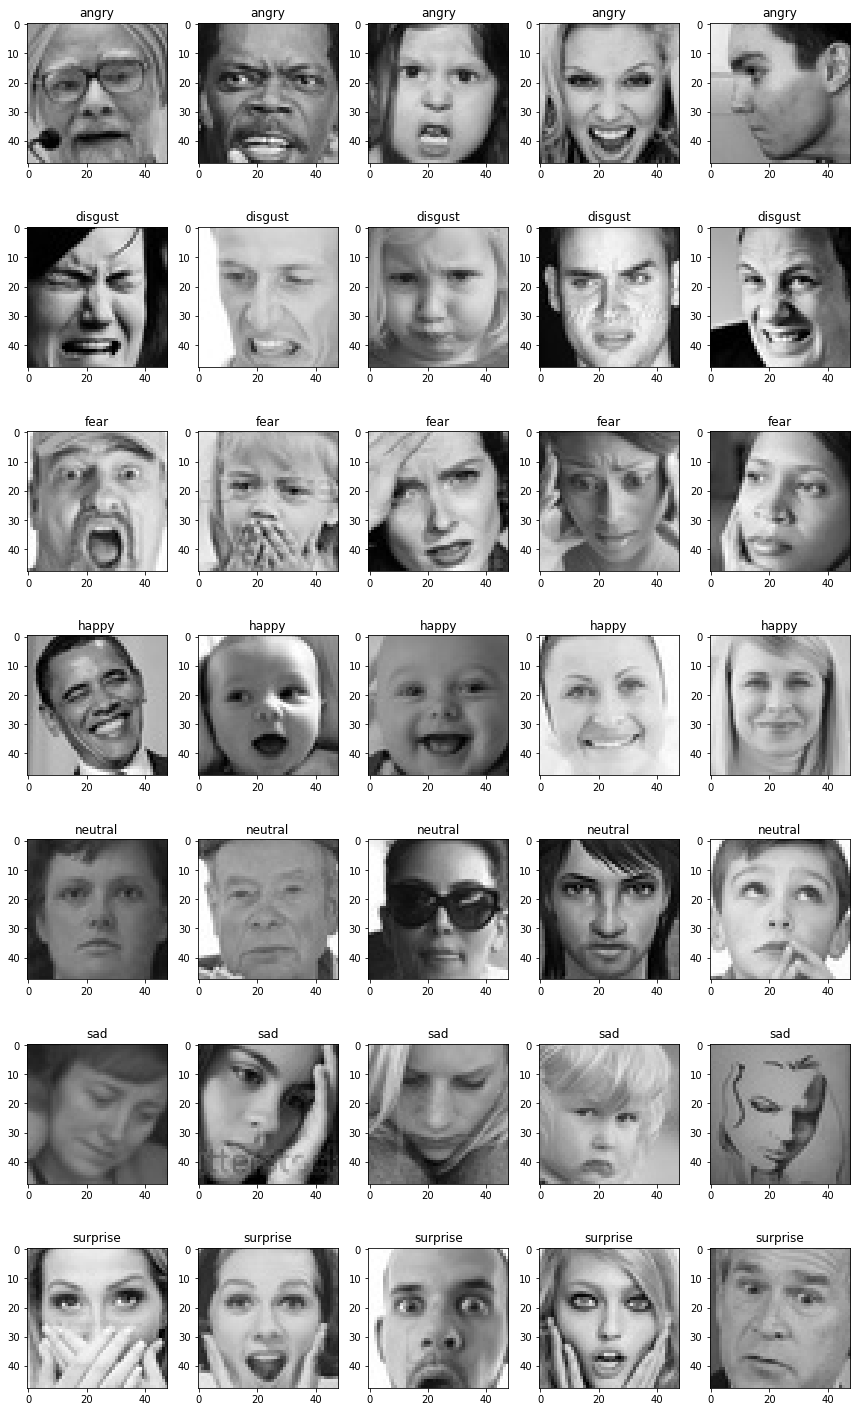

In [5]:
from keras.preprocessing.image import load_img, img_to_array
pic_size = 48

# input path for the images
base_path = "images/"

plt.figure(0, figsize=(12,20))
cpt = 0

for expression in os.listdir(base_path + "train/"):
    for i in range(1,6):
        cpt = cpt + 1
        plt.subplot(7,5,cpt)
        img = load_img(base_path + "train/" + expression + "/" +os.listdir(base_path + "train/" + expression)[i], target_size=(pic_size, pic_size))
        plt.imshow(img, cmap="gray")
        plt.title(expression)

plt.tight_layout()
plt.show()

In [6]:
for expression in os.listdir(base_path + "train"):
    print(str(len(os.listdir(base_path + "train/" + expression))) + " " + expression + " images")


3993 angry images
436 disgust images
4103 fear images
7164 happy images
4982 neutral images
4938 sad images
3205 surprise images


In [7]:
batch_size = 64

# Data generator to augment data for training
datagen_train = ImageDataGenerator(horizontal_flip=True)
train_generator = datagen_train.flow_from_directory(base_path+"train/", 
                                                    target_size=(pic_size,pic_size), 
                                                    color_mode='grayscale',
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   shuffle=True)

# Data generator to augment data for validation
datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_train.flow_from_directory(base_path+"validation/", 
                                                    target_size=(pic_size,pic_size), 
                                                    color_mode='grayscale',
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [8]:
model = Sequential()

# Conv Block 1
model.add(Conv2D(64, (3,3), padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv Block 2
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv Block 3
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv Block 3
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

# Fully connected Block 1
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected Block 2
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
____

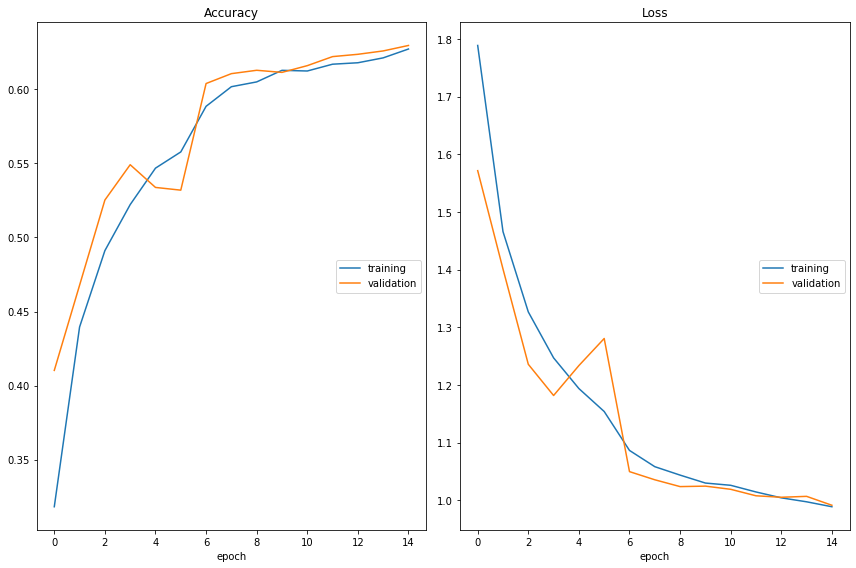

Accuracy
	training         	 (min:    0.318, max:    0.627, cur:    0.627)
	validation       	 (min:    0.410, max:    0.630, cur:    0.630)
Loss
	training         	 (min:    0.989, max:    1.789, cur:    0.989)
	validation       	 (min:    0.991, max:    1.572, cur:    0.991)

Epoch 00015: saving model to model_weights.h5
450/450 [==============================] - 1224s 3s/step - loss: 0.9881 - acc: 0.6273 - val_loss: 0.9912 - val_acc: 0.6297


In [10]:
from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras
#from livelossplot import PlotLossesTensorFlowKeras
from livelossplot.keras import PlotLossesCallback

epochs = 15
steps_per_epoch= train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',
                            save_weights_only=True, mode='max',verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss' , factor=0.1, patience=2, min_lr=0.00001,model='auto')

callbacks = [PlotLossesKeras(), checkpoint, reduce_lr]

history = model.fit(
        x= train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        callbacks=callbacks
)

In [11]:
model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)

In [ ]:
'''predictions = model.predict_generator(generator=validation_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes
class_names = validation_generator.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()'''
